<a href="https://colab.research.google.com/github/jbbonice2/PROJET-RL/blob/main/algoComparatifGreedyUcbGrandiant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Comparaison Greedy , Epsilon-greedy , UCB et Gradient bandit**



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class RowGridWorld:
    def __init__(self, n_cols=10, goal_states=[1, 4, 9], neutral_states=[2, 3, 5], reward=1, step_penalty=-0.1):
        self.n_cols = n_cols
        self.goal_states = goal_states  # États cibles avec récompense positive
        self.neutral_states = neutral_states  # États neutres avec récompense 0
        self.reward = reward
        self.step_penalty = step_penalty
        self.state = 0
        self.done = False

    def reset(self):
        self.state = np.random.randint(0, self.n_cols)  # Commencer à un état aléatoire
        self.done = False
        return self.state

    def step(self, action):
        if self.done:
            return self.state, 0, True

        if action == 0:  # Aller à gauche
            self.state = max(0, self.state - 1)
        elif action == 1:  # Aller à droite
            self.state = min(self.n_cols - 1, self.state + 1)

        # Vérifier si l'agent atteint un bord de la grille
        if self.state == 0 or self.state == self.n_cols - 1:
            self.done = True
            reward = self.reward if self.state in self.goal_states else self.step_penalty
            return self.state, reward, self.done

        # Calcul de la récompense
        if self.state in self.goal_states:  # Si l'état actuel est un état cible
            reward = self.reward
        elif self.state in self.neutral_states:  # Si l'état actuel est un état neutre
            reward = 0
        else:
            reward = self.step_penalty  # Pénalité pour chaque mouvement

        return self.state, reward, self.done

    def render(self):
        grid = ['-' for _ in range(self.n_cols)]
        grid[self.state] = 'A'
        print(" ".join(grid))


# Algorithmes
def greedy(env, n_episodes):
    rewards = []
    Q = np.zeros(2)  # Valeurs estimées pour chaque action (gauche, droite)
    N = np.zeros(2)  # Nombre de fois que chaque action a été choisie
    for _ in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = np.argmax(Q)  # Greedy: Choisir l'action avec la plus haute valeur estimée
            next_state, reward, done = env.step(action)
            N[action] += 1
            Q[action] += (reward - Q[action]) / N[action]  # Mise à jour de la valeur estimée
            total_reward += reward
        rewards.append(total_reward)
    return np.array(rewards)

def epsilon_greedy(env, n_episodes, epsilon=0.3):
    rewards = []
    Q = np.zeros(2)
    N = np.zeros(2)
    for _ in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            if np.random.rand() < epsilon:
                action = np.random.choice([0, 1])  # Exploration
            else:
                action = np.argmax(Q)  # Exploitation
            next_state, reward, done = env.step(action)
            N[action] += 1
            Q[action] += (reward - Q[action]) / N[action]
            total_reward += reward
        rewards.append(total_reward)
    return np.array(rewards)

def ucb(env, n_episodes, c=2):
    rewards = []
    Q = np.zeros(2)
    N = np.zeros(2)
    t = 0
    for _ in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            t += 1
            action = np.argmax(Q + c * np.sqrt(np.log(t + 1) / (N + 1e-5)))  # UCB
            next_state, reward, done = env.step(action)
            N[action] += 1
            Q[action] += (reward - Q[action]) / N[action]
            total_reward += reward
        rewards.append(total_reward)
    return np.array(rewards)

def gradient_bandit(env, n_episodes, alpha=0.3):
    rewards = []
    H = np.zeros(2)  # Valeurs de préférence pour chaque action
    for _ in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            # Sélectionner une action selon les probabilités softmax
            exp = np.exp(H)
            probs = exp / np.sum(exp)
            action = np.random.choice([0, 1], p=probs)

            next_state, reward, done = env.step(action)

            # Mise à jour des préférences H
            baseline = np.mean(reward)
            H[action] += alpha * (reward - baseline)

            total_reward += reward
        rewards.append(total_reward)
    return np.array(rewards)

# Initialisation de l'environnement
env = RowGridWorld(n_cols=10, goal_states=[1, 4, 9], neutral_states=[2, 3, 5], reward=1, step_penalty=-0.1)
n_episodes = 900

# Comparaison des méthodes
greedy_rewards = greedy(env, n_episodes)
epsilon_greedy_rewards = epsilon_greedy(env, n_episodes)
ucb_rewards = ucb(env, n_episodes)
gradient_bandit_rewards = gradient_bandit(env, n_episodes)

# Tracer les courbes des récompenses moyennes cumulatives
plt.figure(figsize=(10, 6))

# Moyennes cumulatives
plt.plot(np.cumsum(greedy_rewards) / (np.arange(n_episodes) + 1), label='Greedy')
plt.plot(np.cumsum(epsilon_greedy_rewards) / (np.arange(n_episodes) + 1), label='Epsilon-Greedy')
plt.plot(np.cumsum(ucb_rewards) / (np.arange(n_episodes) + 1), label='UCB')
plt.plot(np.cumsum(gradient_bandit_rewards) / (np.arange(n_episodes) + 1), label='Gradient Bandit')

# Paramètres du graphique
plt.xlabel('Épisodes')
plt.ylabel('Récompense moyenne cumulative')
plt.title('Comparaison entre Greedy, Epsilon-Greedy, UCB et Gradient Bandit')
plt.legend()
plt.grid(True)
plt.show()


## **comparaison entre Monte carlo prediction , Sarsa et N-step prediction**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Classe RowGridWorld
class RowGridWorld:
    def __init__(self, n_cols=10, goal_states=[1, 4, 9], neutral_states=[2, 3, 5], reward=1, step_penalty=-0.1):
        self.n_cols = n_cols
        self.goal_states = goal_states  # États cibles avec récompense positive
        self.neutral_states = neutral_states  # États neutres avec récompense 0
        self.reward = reward
        self.step_penalty = step_penalty
        self.state = 0
        self.done = False

    def reset(self):
        self.state = np.random.randint(0, self.n_cols)  # Commencer à un état aléatoire
        self.done = False
        return self.state

    def step(self, action):
        if self.done:
            return self.state, 0, True

        if action == 0:  # Aller à gauche
            self.state = max(0, self.state - 1)
        elif action == 1:  # Aller à droite
            self.state = min(self.n_cols - 1, self.state + 1)

        # Vérifier si l'agent atteint un bord de la grille
        if self.state == 0 or self.state == self.n_cols - 1:
            self.done = True
            reward = self.reward if self.state in self.goal_states else self.step_penalty
            return self.state, reward, self.done

        # Calcul de la récompense
        if self.state in self.goal_states:  # Si l'état actuel est un état cible
            reward = self.reward
        elif self.state in self.neutral_states:  # Si l'état actuel est un état neutre
            reward = 0
        else:
            reward = self.step_penalty  # Pénalité pour chaque mouvement

        return self.state, reward, self.done

    def render(self):
        grid = ['-' for _ in range(self.n_cols)]
        grid[self.state] = 'A'
        print(" ".join(grid))


# Monte Carlo Prediction
def monte_carlo_prediction(env, n_episodes, gamma=0.9):
    V = np.zeros(env.n_cols)  # Valeurs des états
    returns = {s: [] for s in range(env.n_cols)}  # Stocker les retours pour chaque état
    rewards_per_episode = []

    for _ in range(n_episodes):
        state = env.reset()
        done = False
        episode = []

        while not done:
            action = np.random.choice([0, 1])  # Politique aléatoire
            next_state, reward, done = env.step(action)
            episode.append((state, reward))
            state = next_state

        G = 0
        visited = set()
        for state, reward in reversed(episode):
            G = gamma * G + reward
            if state not in visited:
                returns[state].append(G)
                V[state] = np.mean(returns[state])
                visited.add(state)

        rewards_per_episode.append(sum(r for _, r in episode))
    return V, np.array(rewards_per_episode)


# SARSA
def sarsa(env, n_episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
    Q = np.zeros((env.n_cols, 2))  # Valeurs état-action
    rewards_per_episode = []

    for _ in range(n_episodes):
        state = env.reset()
        action = np.random.choice([0, 1]) if np.random.rand() < epsilon else np.argmax(Q[state])
        done = False
        total_reward = 0

        while not done:
            next_state, reward, done = env.step(action)
            next_action = np.random.choice([0, 1]) if np.random.rand() < epsilon else np.argmax(Q[next_state])

            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])

            state = next_state
            action = next_action
            total_reward += reward

        rewards_per_episode.append(total_reward)
    return Q, np.array(rewards_per_episode)


# n-Step Prediction
def n_step_prediction(env, n_episodes, n=3, alpha=0.1, gamma=0.9):
    V = np.zeros(env.n_cols)
    rewards_per_episode = []

    for _ in range(n_episodes):
        state = env.reset()
        done = False
        states = [state]
        rewards = []
        T = float('inf')
        total_reward = 0

        t = 0
        while True:
            if t < T:
                action = np.random.choice([0, 1])  # Politique aléatoire
                next_state, reward, done = env.step(action)
                rewards.append(reward)
                states.append(next_state)
                if done:
                    T = t + 1

            tau = t - n + 1
            if tau >= 0:
                G = sum(gamma ** (i - tau) * rewards[i] for i in range(tau, min(tau + n, T)))
                if tau + n < T:
                    G += gamma ** n * V[states[tau + n]]
                V[states[tau]] += alpha * (G - V[states[tau]])

            if tau == T - 1:
                break
            t += 1
            total_reward += sum(rewards)

        rewards_per_episode.append(total_reward)
    return V, np.array(rewards_per_episode)


# Initialisation de l'environnement
env = RowGridWorld(n_cols=10, goal_states=[1, 4, 9], neutral_states=[2, 3, 5], reward=1, step_penalty=-0.1)
n_episodes = 500

# Comparaison des méthodes
_, mc_rewards = monte_carlo_prediction(env, n_episodes)
_, sarsa_rewards = sarsa(env, n_episodes)
_, n_step_rewards = n_step_prediction(env, n_episodes)

# Tracer les courbes des récompenses moyennes cumulatives
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(mc_rewards) / (np.arange(n_episodes) + 1), label='Monte Carlo Prediction')
plt.plot(np.cumsum(sarsa_rewards) / (np.arange(n_episodes) + 1), label='SARSA')
plt.plot(np.cumsum(n_step_rewards) / (np.arange(n_episodes) + 1), label='n-Step Prediction')

# Paramètres du graphique
plt.xlabel('Épisodes')
plt.ylabel('Récompense moyenne cumulative')
plt.title('Comparaison entre Monte Carlo Prediction, SARSA et n-Step Prediction')
plt.legend()
plt.grid(True)
plt.show()


## **comparaison entre Q-learning , Sarsa et N-step sarsa**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Classe RowGridWorld
class RowGridWorld:
    def __init__(self, n_cols=10, goal_states=[1, 4, 9], neutral_states=[2, 3, 5], reward=1, step_penalty=-0.1):
        self.n_cols = n_cols
        self.goal_states = goal_states  # États cibles avec récompense positive
        self.neutral_states = neutral_states  # États neutres avec récompense 0
        self.reward = reward
        self.step_penalty = step_penalty
        self.state = 0
        self.done = False

    def reset(self):
        self.state = np.random.randint(0, self.n_cols)  # Commencer à un état aléatoire
        self.done = False
        return self.state

    def step(self, action):
        if self.done:
            return self.state, 0, True

        if action == 0:  # Aller à gauche
            self.state = max(0, self.state - 1)
        elif action == 1:  # Aller à droite
            self.state = min(self.n_cols - 1, self.state + 1)

        # Vérifier si l'agent atteint un bord de la grille
        if self.state == 0 or self.state == self.n_cols - 1:
            self.done = True
            reward = self.reward if self.state in self.goal_states else self.step_penalty
            return self.state, reward, self.done

        # Calcul de la récompense
        if self.state in self.goal_states:  # Si l'état actuel est un état cible
            reward = self.reward
        elif self.state in self.neutral_states:  # Si l'état actuel est un état neutre
            reward = 0
        else:
            reward = self.step_penalty  # Pénalité pour chaque mouvement

        return self.state, reward, self.done

    def render(self):
        grid = ['-' for _ in range(self.n_cols)]
        grid[self.state] = 'A'
        print(" ".join(grid))


# Q-Learning
def q_learning(env, n_episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
    Q = np.zeros((env.n_cols, 2))  # Valeurs état-action
    rewards_per_episode = []

    for _ in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = np.random.choice([0, 1]) if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, done = env.step(action)
            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)
    return Q, np.array(rewards_per_episode)


# SARSA
def sarsa(env, n_episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
    Q = np.zeros((env.n_cols, 2))  # Valeurs état-action
    rewards_per_episode = []

    for _ in range(n_episodes):
        state = env.reset()
        action = np.random.choice([0, 1]) if np.random.rand() < epsilon else np.argmax(Q[state])
        done = False
        total_reward = 0

        while not done:
            next_state, reward, done = env.step(action)
            next_action = np.random.choice([0, 1]) if np.random.rand() < epsilon else np.argmax(Q[next_state])
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
            state, action = next_state, next_action
            total_reward += reward

        rewards_per_episode.append(total_reward)
    return Q, np.array(rewards_per_episode)


# n-Step SARSA
def n_step_sarsa(env, n_episodes, n=3, alpha=0.1, gamma=0.9, epsilon=0.1):
    Q = np.zeros((env.n_cols, 2))  # Valeurs état-action
    rewards_per_episode = []

    for _ in range(n_episodes):
        state = env.reset()
        action = np.random.choice([0, 1]) if np.random.rand() < epsilon else np.argmax(Q[state])
        states = [state]
        actions = [action]
        rewards = []
        T = float('inf')
        total_reward = 0

        t = 0
        while True:
            if t < T:
                next_state, reward, done = env.step(action)
                rewards.append(reward)
                if done:
                    T = t + 1
                else:
                    next_action = np.random.choice([0, 1]) if np.random.rand() < epsilon else np.argmax(Q[next_state])
                    states.append(next_state)
                    actions.append(next_action)

            tau = t - n + 1
            if tau >= 0:
                G = sum(gamma ** (i - tau) * rewards[i] for i in range(tau, min(tau + n, T)))
                if tau + n < T:
                    G += gamma ** n * Q[states[tau + n], actions[tau + n]]
                Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

            if tau == T - 1:
                break
            t += 1
            total_reward += sum(rewards)

        rewards_per_episode.append(total_reward)
    return Q, np.array(rewards_per_episode)


# Initialisation de l'environnement
env = RowGridWorld(n_cols=10, goal_states=[1, 4, 9], neutral_states=[2, 3, 5], reward=1, step_penalty=-0.1)
n_episodes = 500

# Comparaison des méthodes
_, q_learning_rewards = q_learning(env, n_episodes)
_, sarsa_rewards = sarsa(env, n_episodes)
_, n_step_sarsa_rewards = n_step_sarsa(env, n_episodes)

# Tracer les courbes des récompenses moyennes cumulatives
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(q_learning_rewards) / (np.arange(n_episodes) + 1), label='Q-Learning')
plt.plot(np.cumsum(sarsa_rewards) / (np.arange(n_episodes) + 1), label='SARSA')
plt.plot(np.cumsum(n_step_sarsa_rewards) / (np.arange(n_episodes) + 1), label='n-Step SARSA')

# Paramètres du graphique
plt.xlabel('Épisodes')
plt.ylabel('Récompense moyenne cumulative')
plt.title('Comparaison entre Q-Learning, SARSA et n-Step SARSA')
plt.legend()
plt.grid(True)
plt.show()


Récompenses cumulées par épisode : [-0.08760877859139075, 2.106147465454759, 2.558857275523577, 1.455199259972923, 6.261080637937912, 5.333857266131446, 2.458094861336069, 5.327660779122566, 3.5949859053397852, 5.678066094731177, 1.753461179615858, 13.327315592435852, 15.252638118486525, 15.586667362966143, 15.360206847611181, 13.451669211449197, 10.66574528364946, 19.040067015106267, 20.42623698977421, 11.212057424346419, 37.00346260028153, 21.95632565146236, 32.51579224728729, 31.506254049498107, 27.12147412906546, 18.76702360286399, 20.838999981679244, 19.18595123054101, 8.161396229966146, 11.086226385518293, 12.412299611406238, 14.728224094316266, 13.308637081122438, 12.731411929039286, 9.694112539539601, 19.46039358479775, 12.500186949743318, 17.750508296281676, 23.35671696293194, 24.185642001150377, 23.208799258571876, 19.698228396060383, 23.55691371221514, 31.63507194180576, 28.08183335267667, 22.924402072166835, 24.498770653690805, 31.656669943803298, 32.717134625970786, 33.260

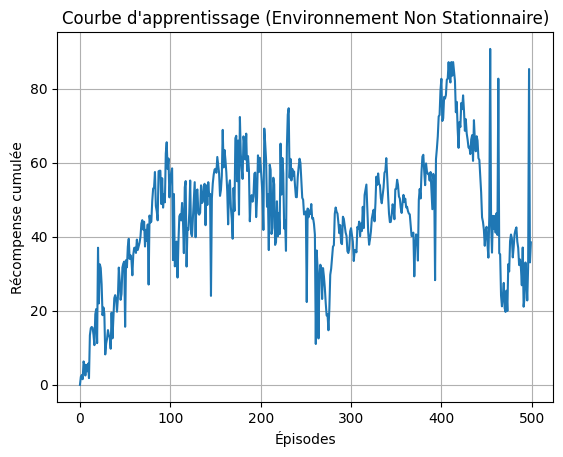

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt

class DynamicMazeEnvironment:
    def __init__(self, size):
        self.size = size
        self.state = (0, 0)  # Position de départ
        self.goal = (size - 1, size - 1)
        self.rewards = self.initialize_rewards()

    def initialize_rewards(self):
        rewards = np.zeros((self.size, self.size))
        rewards[self.goal] = 1.0  # Récompense à la sortie
        return rewards

    def step(self, action):
        x, y = self.state
        if action == 0:  # Haut
            x = max(0, x - 1)
        elif action == 1:  # Bas
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Gauche
            y = max(0, y - 1)
        elif action == 3:  # Droite
            y = min(self.size - 1, y + 1)

        self.state = (x, y)
        reward = self.rewards[x, y]

        # Dynamisme : la récompense change légèrement
        self.rewards += np.random.normal(0, 0.01, self.rewards.shape)
        return self.state, reward

    def reset(self):
        self.state = (0, 0)
        return self.state

class SARSAAgent:
    def __init__(self, size, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.q_values = np.zeros((size, size, 4))  # Q-valeurs pour chaque état et action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def choose_action(self, state):
        if random.random() < self.epsilon:  # Exploration
            return random.randint(0, 3)
        x, y = state
        return np.argmax(self.q_values[x, y])  # Exploitation

    def update(self, state, action, reward, next_state, next_action):
        x, y = state
        nx, ny = next_state
        target = reward + self.gamma * self.q_values[nx, ny, next_action]
        self.q_values[x, y, action] += self.alpha * (target - self.q_values[x, y, action])

# Initialisation
env = DynamicMazeEnvironment(size=5)
agent = SARSAAgent(size=5)

# Entraînement
episodes = 500
steps_per_episode = 50
rewards_per_episode = []

for episode in range(episodes):
    state = env.reset()
    action = agent.choose_action(state)
    total_reward = 0

    for step in range(steps_per_episode):
        next_state, reward = env.step(action)
        next_action = agent.choose_action(next_state)

        agent.update(state, action, reward, next_state, next_action)
        state, action = next_state, next_action

        total_reward += reward
        if state == env.goal:
            break
    rewards_per_episode.append(total_reward)

# Affichage des résultats
print("Récompenses cumulées par épisode :", rewards_per_episode)

# Courbe d'apprentissage
plt.plot(rewards_per_episode)
plt.title("Courbe d'apprentissage (Environnement Non Stationnaire)")
plt.xlabel("Épisodes")
plt.ylabel("Récompense cumulée")
plt.grid()
plt.show()


Récompenses cumulées par épisode : [0.9576917942180219, 4.307164953341702, 4.577484332594244, 1.3500417077306341, -2.168160522371182, 3.920007706980819, 4.1282135544081, -3.462922518370224, 3.4369142282920286, 4.630988721017375, 6.490017745655593, 11.214480527878347, 3.5326871715654975, 3.1517001806608507, 8.858543160234806, -2.2979090187994595, -2.7227249804941893, -1.4065397793548895, 9.161465126869736, 8.053639473655558, 7.840316829176671, 7.360668020618496, 11.161793203588696, 8.280169655088098, 7.80694144898818, 10.064305107521664, 8.091625285862051, 12.588433182730698, 20.70882649261649, 16.606079102307167, 12.544044074764072, 7.042376920715097, 4.523945821688515, 3.9567032927717047, 6.451117795376978, 10.938873874573096, 8.74477346820828, 11.050124039756179, 8.58007954932229, 7.405396658553121, 10.13442410786048, 22.244935133383112, 8.176404908813984, 9.128114689337702, 10.329890415986984, 27.33557225684909, 9.324971184465237, 8.222854462812888, 8.519379842504916, 5.278157117004

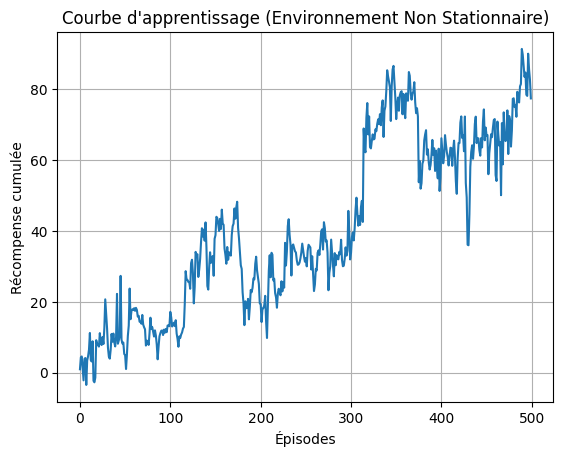

In [3]:
# Initialisation
env = DynamicMazeEnvironment(size=5)
agent = SARSAAgent(size=5)

# Entraînement
episodes = 500
steps_per_episode = 50
rewards_per_episode = []
actions_rewards_per_episode = {}  # Dictionnaire pour stocker actions et récompenses

for episode in range(episodes):
    state = env.reset()
    action = agent.choose_action(state)
    total_reward = 0
    actions_rewards_per_episode[episode] = []  # Initialiser la liste pour cet épisode

    for step in range(steps_per_episode):
        next_state, reward = env.step(action)
        next_action = agent.choose_action(next_state)

        # Enregistrer l'action et la récompense
        actions_rewards_per_episode[episode].append({"state": state, "action": action, "reward": reward})

        agent.update(state, action, reward, next_state, next_action)
        state, action = next_state, next_action

        total_reward += reward
        if state == env.goal:
            break
    rewards_per_episode.append(total_reward)

# Affichage des résultats
print("Récompenses cumulées par épisode :", rewards_per_episode)
print("\nDictionnaire actions-récompenses par épisode :")
for episode, actions_rewards in actions_rewards_per_episode.items():
    print(f"Épisode {episode}: {actions_rewards}")

# Courbe d'apprentissage
plt.plot(rewards_per_episode)
plt.title("Courbe d'apprentissage (Environnement Non Stationnaire)")
plt.xlabel("Épisodes")
plt.ylabel("Récompense cumulée")
plt.grid()
plt.show()


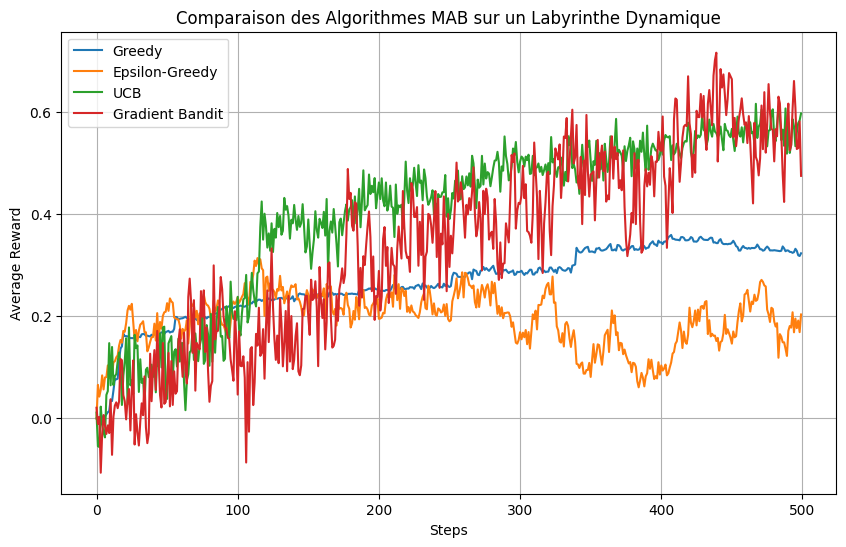

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Environnement dynamique adapté au Multi-Armed Bandit
class DynamicMazeBandit:
    def __init__(self, size):
        self.size = size
        self.state = (0, 0)  # Position de départ
        self.goal = (size - 1, size - 1)
        self.rewards = self.initialize_rewards()
        self.k = 4  # 4 actions possibles : haut, bas, gauche, droite

    def initialize_rewards(self):
        rewards = np.zeros((self.size, self.size))
        rewards[self.goal] = 1.0  # Récompense à la sortie
        return rewards

    def step(self, action):
        x, y = self.state
        if action == 0:  # Haut
            x = max(0, x - 1)
        elif action == 1:  # Bas
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Gauche
            y = max(0, y - 1)
        elif action == 3:  # Droite
            y = min(self.size - 1, y + 1)

        self.state = (x, y)
        reward = self.rewards[x, y]

        # Dynamisme : la récompense change légèrement
        self.rewards += np.random.normal(0, 0.01, self.rewards.shape)
        return reward

    def reset(self):
        self.state = (0, 0)

# Algorithmes MAB adaptés
def greedy(env, steps):
    q_estimates = np.zeros(env.k)
    action_counts = np.zeros(env.k)
    rewards = []
    for _ in range(steps):
        action = np.argmax(q_estimates)
        reward = env.step(action)
        action_counts[action] += 1
        q_estimates[action] += (reward - q_estimates[action]) / action_counts[action]
        rewards.append(reward)
    return rewards

def epsilon_greedy(env, steps, epsilon=0.1):
    q_estimates = np.zeros(env.k)
    action_counts = np.zeros(env.k)
    rewards = []
    for _ in range(steps):
        if np.random.rand() < epsilon:
            action = np.random.choice(env.k)
        else:
            action = np.argmax(q_estimates)
        reward = env.step(action)
        action_counts[action] += 1
        q_estimates[action] += (reward - q_estimates[action]) / action_counts[action]
        rewards.append(reward)
    return rewards

def ucb(env, steps, c=2):
    q_estimates = np.zeros(env.k)
    action_counts = np.zeros(env.k)
    rewards = []
    for t in range(1, steps + 1):
        confidence_bounds = q_estimates + c * np.sqrt(np.log(t) / (action_counts + 1e-5))
        action = np.argmax(confidence_bounds)
        reward = env.step(action)
        action_counts[action] += 1
        q_estimates[action] += (reward - q_estimates[action]) / action_counts[action]
        rewards.append(reward)
    return rewards

def gradient_bandit(env, steps, alpha=0.1):
    preferences = np.zeros(env.k)
    action_probs = np.ones(env.k) / env.k
    rewards = []
    avg_reward = 0
    for t in range(1, steps + 1):
        action = np.random.choice(env.k, p=action_probs)
        reward = env.step(action)
        avg_reward += (reward - avg_reward) / t
        rewards.append(reward)
        preferences[action] += alpha * (reward - avg_reward) * (1 - action_probs[action])
        preferences -= alpha * (reward - avg_reward) * action_probs
        action_probs = np.exp(preferences) / np.sum(np.exp(preferences))
    return rewards

# Comparaison des algorithmes
size = 5
steps = 500
episodes = 50

algorithms = {
    "Greedy": greedy,
    "Epsilon-Greedy": lambda env, s: epsilon_greedy(env, s, epsilon=0.1),
    "UCB": lambda env, s: ucb(env, s, c=2),
    "Gradient Bandit": gradient_bandit
}

average_rewards = {name: np.zeros(steps) for name in algorithms}

for episode in range(episodes):
    env = DynamicMazeBandit(size)
    for name, algorithm in algorithms.items():
        env.reset()
        rewards = algorithm(env, steps)
        average_rewards[name] += np.array(rewards)

# Moyenne des récompenses par épisode
for name in average_rewards:
    average_rewards[name] /= episodes

# Tracé des courbes
plt.figure(figsize=(10, 6))
for name, rewards in average_rewards.items():
    plt.plot(rewards, label=name)
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Comparaison des Algorithmes MAB sur un Labyrinthe Dynamique")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Environnement
class DynamicMazeEnvironment:
    def __init__(self, size):
        self.size = size
        self.state = (0, 0)  # Position de départ
        self.goal = (size - 1, size - 1)
        self.rewards = self.initialize_rewards()

    def initialize_rewards(self):
        rewards = np.zeros((self.size, self.size))
        rewards[self.goal] = 1.0  # Récompense à la sortie
        return rewards

    def step(self, action):
        x, y = self.state
        if action == 0:  # Haut
            x = max(0, x - 1)
        elif action == 1:  # Bas
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Gauche
            y = max(0, y - 1)
        elif action == 3:  # Droite
            y = min(self.size - 1, y + 1)

        self.state = (x, y)
        reward = self.rewards[x, y]

        # Dynamisme : la récompense change légèrement
        self.rewards += np.random.normal(0, 0.01, self.rewards.shape)
        return self.state, reward

    def reset(self):
        self.state = (0, 0)
        return self.state

# Algorithmes

# Monte Carlo Prediction
def monte_carlo(env, episodes, alpha=0.1, gamma=0.9):
    q_values = np.zeros((env.size, env.size, 4))  # Q-valeurs
    returns = {}  # Pour stocker les retours

    for episode in range(episodes):
        state = env.reset()
        episode_memory = []  # Stocker (state, action, reward)

        # Génération de l'épisode
        while True:
            action = random.randint(0, 3)  # Politique aléatoire
            next_state, reward = env.step(action)
            episode_memory.append((state, action, reward))
            if next_state == env.goal:
                break
            state = next_state

        # Calcul des retours
        g = 0
        for state, action, reward in reversed(episode_memory):
            g = gamma * g + reward
            if (state, action) not in [(s, a) for s, a, r in episode_memory[:-1]]:
                x, y = state
                q_values[x, y, action] += alpha * (g - q_values[x, y, action])

    return q_values

# SARSA
def sarsa(env, episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_values = np.zeros((env.size, env.size, 4))  # Q-valeurs

    for episode in range(episodes):
        state = env.reset()
        action = np.argmax(q_values[state]) if random.random() > epsilon else random.randint(0, 3)

        while True:
            next_state, reward = env.step(action)
            next_action = np.argmax(q_values[next_state]) if random.random() > epsilon else random.randint(0, 3)

            x, y = state
            nx, ny = next_state
            q_values[x, y, action] += alpha * (reward + gamma * q_values[nx, ny, next_action] - q_values[x, y, action])

            state, action = next_state, next_action
            if state == env.goal:
                break

    return q_values

# N-Step Prediction
def n_step_prediction(env, episodes, n=3, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_values = np.zeros((env.size, env.size, 4))  # Q-valeurs

    for episode in range(episodes):
        state = env.reset()
        action = np.argmax(q_values[state]) if random.random() > epsilon else random.randint(0, 3)
        trajectory = []  # Stocker (state, action, reward)

        while True:
            next_state, reward = env.step(action)
            trajectory.append((state, action, reward))

            if len(trajectory) >= n:
                g = sum([gamma ** i * r for i, (_, _, r) in enumerate(trajectory[:n])])
                if len(trajectory) > n:
                    g += gamma ** n * q_values[trajectory[n][0]][trajectory[n][1]][trajectory[n][2]]
                x, y = trajectory[0][0]
                a = trajectory[0][1]
                q_values[x, y, a] += alpha * (g - q_values[x, y, a])
                trajectory.pop(0)

            state, action = next_state, np.argmax(q_values[next_state]) if random.random() > epsilon else random.randint(0, 3)
            if state == env.goal:
                break

        # Mise à jour pour les derniers états
        while trajectory:
            g = sum([gamma ** i * r for i, (_, _, r) in enumerate(trajectory)])
            x, y = trajectory[0][0]
            a = trajectory[0][1]
            q_values[x, y, a] += alpha * (g - q_values[x, y, a])
            trajectory.pop(0)

    return q_values

# Comparaison
episodes = 500
env = DynamicMazeEnvironment(size=5)

q_mc = monte_carlo(env, episodes)
q_sarsa = sarsa(env, episodes)
q_nstep = n_step_prediction(env, episodes, n=3)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(np.sum(q_mc, axis=(0, 1)), label="Monte Carlo")
plt.plot(np.sum(q_sarsa, axis=(0, 1)), label="SARSA")
plt.plot(np.sum(q_nstep, axis=(0, 1)), label="N-Step (n=3)")
plt.xlabel("Actions")
plt.ylabel("Valeurs Q cumulées")
plt.title("Comparaison entre Monte Carlo, SARSA, et N-Step Prediction")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Environnement dynamique (déjà défini)
class DynamicMazeEnvironment:
    def __init__(self, size):
        self.size = size
        self.state = (0, 0)  # Position de départ
        self.goal = (size - 1, size - 1)
        self.rewards = self.initialize_rewards()

    def initialize_rewards(self):
        rewards = np.zeros((self.size, self.size))
        rewards[self.goal] = 1.0  # Récompense à la sortie
        return rewards

    def step(self, action):
        x, y = self.state
        if action == 0:  # Haut
            x = max(0, x - 1)
        elif action == 1:  # Bas
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Gauche
            y = max(0, y - 1)
        elif action == 3:  # Droite
            y = min(self.size - 1, y + 1)

        self.state = (x, y)
        reward = self.rewards[x, y]

        # Dynamisme : la récompense change légèrement
        self.rewards += np.random.normal(0, 0.01, self.rewards.shape)
        return self.state, reward

    def reset(self):
        self.state = (0, 0)
        return self.state

# Algorithmes

# Q-learning
def q_learning(env, episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_values = np.zeros((env.size, env.size, 4))  # Q-valeurs

    for episode in range(episodes):
        state = env.reset()
        while True:
            x, y = state
            # Choisir une action (epsilon-greedy)
            if random.random() < epsilon:
                action = random.randint(0, 3)
            else:
                action = np.argmax(q_values[x, y])

            next_state, reward = env.step(action)
            nx, ny = next_state
            # Mise à jour de Q-learning
            q_values[x, y, action] += alpha * (
                reward + gamma * np.max(q_values[nx, ny]) - q_values[x, y, action]
            )

            state = next_state
            if state == env.goal:
                break

    return q_values

# SARSA
def sarsa(env, episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_values = np.zeros((env.size, env.size, 4))  # Q-valeurs

    for episode in range(episodes):
        state = env.reset()
        action = np.argmax(q_values[state]) if random.random() > epsilon else random.randint(0, 3)

        while True:
            next_state, reward = env.step(action)
            next_action = np.argmax(q_values[next_state]) if random.random() > epsilon else random.randint(0, 3)

            x, y = state
            nx, ny = next_state
            q_values[x, y, action] += alpha * (reward + gamma * q_values[nx, ny, next_action] - q_values[x, y, action])

            state, action = next_state, next_action
            if state == env.goal:
                break

    return q_values

# N-Step SARSA
def n_step_sarsa(env, episodes, n=3, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_values = np.zeros((env.size, env.size, 4))  # Q-valeurs

    for episode in range(episodes):
        state = env.reset()
        action = np.argmax(q_values[state]) if random.random() > epsilon else random.randint(0, 3)
        trajectory = []  # Stocker (state, action, reward)

        while True:
            next_state, reward = env.step(action)
            trajectory.append((state, action, reward))

            if len(trajectory) >= n:
                g = sum([gamma ** i * r for i, (_, _, r) in enumerate(trajectory[:n])])
                if len(trajectory) > n:
                    g += gamma ** n * q_values[trajectory[n][0]][trajectory[n][1]][trajectory[n][2]]
                x, y = trajectory[0][0]
                a = trajectory[0][1]
                q_values[x, y, a] += alpha * (g - q_values[x, y, a])
                trajectory.pop(0)

            state, action = next_state, np.argmax(q_values[next_state]) if random.random() > epsilon else random.randint(0, 3)
            if state == env.goal:
                break

        # Mise à jour pour les derniers états
        while trajectory:
            g = sum([gamma ** i * r for i, (_, _, r) in enumerate(trajectory)])
            x, y = trajectory[0][0]
            a = trajectory[0][1]
            q_values[x, y, a] += alpha * (g - q_values[x, y, a])
            trajectory.pop(0)

    return q_values

# Comparaison
episodes = 500
env = DynamicMazeEnvironment(size=5)

q_qlearning = q_learning(env, episodes)
q_sarsa = sarsa(env, episodes)
q_nstep_sarsa = n_step_sarsa(env, episodes, n=3)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(np.sum(q_qlearning, axis=(0, 1)), label="Q-Learning")
plt.plot(np.sum(q_sarsa, axis=(0, 1)), label="SARSA")
plt.plot(np.sum(q_nstep_sarsa, axis=(0, 1)), label="N-Step SARSA (n=3)")
plt.xlabel("Actions")
plt.ylabel("Valeurs Q cumulées")
plt.title("Comparaison entre Q-Learning, SARSA, et N-Step SARSA")
plt.legend()
plt.grid()
plt.show()
